# Where is Waldo?

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import pandas as pd
import numpy as np
from PIL import Image
import os
import random
import csv

import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler


from tqdm import tqdm

/home/rosa/.local/lib/python3.10/site-packages/anaconda3/envs/dl-waldo/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rosa/.local/lib/python3.10/site-packages/anaconda3/envs/dl-waldo/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available
print(device)

cuda


## Data Loading

In [3]:
!apt-get install git

/bin/bash: line 1: apt-get: command not found


In [4]:
!git clone https://github.com/vc1492a/Hey-Waldo.git

Cloning into 'Hey-Waldo'...
remote: Enumerating objects: 18822, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
^Cceiving objects:   3% (723/18822), 5.58 MiB | 806.00 KiB/s  
fetch-pack: unexpected disconnect while reading sideband packet


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform_dataset_step1 = transforms.Compose([
    transforms.Normalize(mean, std),  # Apply normalization using the computed mean and std
    transforms.RandomHorizontalFlip(p=0.5),
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
])

In [13]:
# Custom Dataset "WaldoDataset"
class WaldoDataset(Dataset):
    def __init__(self, directories, reshape_size, transform=None):
        self.filenames = []
        self.labels = []
        self.reshape_size = reshape_size
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

        # Loop through the directories
        for directory, label in directories:
            for fname in os.listdir(directory):
                if fname.lower().endswith('.jpg'):
                    full_path = os.path.join(directory, fname)
                    self.filenames.append(full_path)
                    self.labels.append(label)

    # Get length
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load an image
        img = Image.open(self.filenames[idx])

        # Resize image
        img = img.resize(self.reshape_size)

        # Apply the transformation to tensor
        if self.transform:
            img = self.transform(img)

        img_tensor = self.to_tensor(img)

        # Get label
        label = self.labels[idx]

        return img_tensor, label

In [14]:
# Transformation to tensor
# tensor_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor()
# ])

# Directories which contain
directories = [
    # Reshape all images to 128x128
    ("./data/64/waldo", 1),
    ("./data/64/notwaldo", 0),
    ("./data/128/waldo", 1),
    ("./data/128/notwaldo", 0)
]

# Create the dataset
waldo_dataset = WaldoDataset(directories, 128)

ValueError: not enough values to unpack (expected 3, got 2)

In [15]:
# Calculate split sizes
total_size = len(waldo_dataset)
test_size = int(0.1 * total_size)
train_eval_size = total_size - test_size
train_size = int(0.9 * train_eval_size)
val_size = train_eval_size - train_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(waldo_dataset, [train_size, val_size, test_size])

# Count labels in each subset
def count_labels_in_subset(dataset, subset):
    label_0_count = 0
    label_1_count = 0

    for idx in subset.indices:
        label = dataset.labels[idx]
        if label == 0:
            label_0_count += 1
        elif label == 1:
            label_1_count += 1

    return label_0_count, label_1_count

label_0_train_size, label_1_train_size = count_labels_in_subset(waldo_dataset, train_dataset)
label_0_val_size, label_1_val_size = count_labels_in_subset(waldo_dataset, val_dataset)
label_0_test_size, label_1_test_size = count_labels_in_subset(waldo_dataset, test_dataset)

# Print dataset statistics
print(f"Length of whole dataset: {len(waldo_dataset)}")
print("----------------------------------------------------------")
print(f"Length of the training set: {len(train_dataset)}")
print(f"Number of label 0 in the training set: {label_0_train_size}")
print(f"Number of label 1 in the training set: {label_1_train_size}")
print("----------------------------------------------------------")
print(f"Length of the validation set: {len(val_dataset)}")
print(f"Number of label 0 in the validation set: {label_0_val_size}")
print(f"Number of label 1 in the validation set: {label_1_val_size}")
print("----------------------------------------------------------")
print(f"Length of the test set: {len(test_dataset)}")
print(f"Number of label 0 in the test set: {label_0_test_size}")
print(f"Number of label 1 in the test set: {label_1_test_size}")

Length of whole dataset: 6720
----------------------------------------------------------
Length of the training set: 5443
Number of label 0 in the training set: 5388
Number of label 1 in the training set: 55
----------------------------------------------------------
Length of the validation set: 605
Number of label 0 in the validation set: 597
Number of label 1 in the validation set: 8
----------------------------------------------------------
Length of the test set: 672
Number of label 0 in the test set: 669
Number of label 1 in the test set: 3


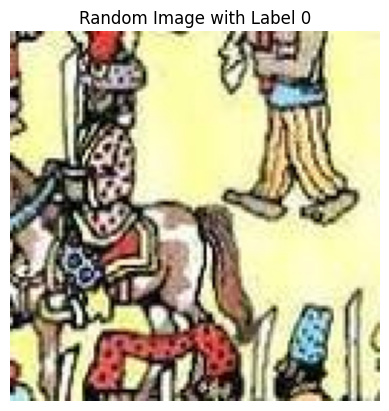

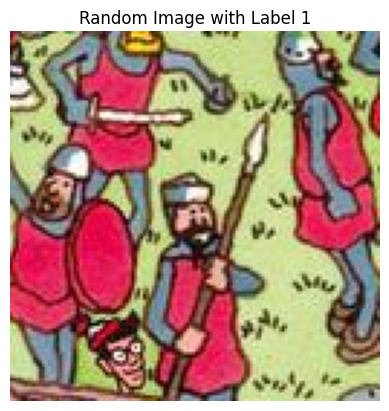

In [16]:
def show_random_image_from_each_label(dataset):
    # Get unique labels in the dataset (0 & 1)
    unique_labels = set(dataset.labels)
    # Iterate for each unique label
    for label in unique_labels:
        # Find indices for current label
        indices_for_label = [i for i, l in enumerate(dataset.labels) if l == label]

        # Choose a random index for the current label
        random_index = random.choice(indices_for_label)
        # Get the image and label
        image, _ = dataset[random_index]

        # Display the random chosen image with the label
        plt.figure()
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Random Image with Label {label}")
        plt.axis('off')
        plt.show()

show_random_image_from_each_label(waldo_dataset)

## Data Processing

In [17]:
def compute_mean_std(dataset):
    sum_rgb = torch.zeros(3)
    sum_rgb_squared = torch.zeros(3)
    num_pixels = 0

    for img, _ in dataset:
        img = img.view(3, -1)  # Flatten the image to get the pixel values for each channel
        sum_rgb += img.sum(dim=1)  # Sum up all the pixel values for each RGB channel
        sum_rgb_squared += (img ** 2).sum(dim=1)  # Sum up the squares of all pixel values for each RGB channel
        num_pixels += img.shape[1]  # Count the total number of pixels processed

    mean = sum_rgb / num_pixels  # Compute the mean for each RGB channel
    std = (sum_rgb_squared / num_pixels - mean ** 2).sqrt()  # Compute the standard deviation for each RGB channel

    return mean, std

mean_train, std_train = compute_mean_std(train_dataset)
print("Mean of RGB channels:", mean_train)
print("Standard Deviation of RGB channels:", std_train)

Mean of RGB channels: tensor([0.6359, 0.5850, 0.4927])
Standard Deviation of RGB channels: tensor([0.2647, 0.2730, 0.2747])


In [18]:
class Patchify(nn.Module):
    def __init__(self, img_size=128, patch_size=16, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x

# Other classes (FeedForward, MultiHeadAttention, Transformer) remain unchanged
class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.heads = heads

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)

        self.out_proj = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape

        x = self.norm(x)         # (B, N, C)

        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)

        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) and permute heads which yields a shape of (B, num_heads, N, dim_head)
        # each of the heads, should have (N, dim_head)
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # (B, num_heads, N, dim_head) with (B, num_heads, N, dim_head) --> (B, num_heads, N, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))

        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> (B, N, num_heads, dim_head) --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)   # or we can use .reshape(B, N, -1) rather than .flatten(2)
        out = self.out_proj(out)
        return out


class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout = 0.):
        super().__init__()

        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])

        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, image_size=128, patch_size=16, num_classes=2, dim=768, num_layers=6, heads=12, dropout=0.1):
        super().__init__()
        self.patchify = Patchify(image_size, patch_size, dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = self.patchify(x)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_encoding
        x = self.transformer(x)
        x = x[:, 0]  # Take the CLS token
        x = self.classifier(x)
        return x

## Step 1: Triplet Loss

In [19]:
class TripletWaldoDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.labels = [label for _, label in subset]
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in np.unique(self.labels)}

        # Precompute negative indices for efficiency
        self.label_to_negative_indices = {label: np.where(np.array(self.labels) != label)[0]
                                          for label in np.unique(self.labels)}

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.subset[idx]
        if self.transform:
            anchor_img = self.transform(anchor_img)

        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])

        negative_label = np.random.choice(list(self.label_to_negative_indices.keys()))
        negative_idx = np.random.choice(self.label_to_negative_indices[negative_label])

        positive_img, _ = self.subset[positive_idx]
        negative_img, _ = self.subset[negative_idx]

        if self.transform:
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img, anchor_label

In [20]:
transform_dataset_step_1 = transforms.Compose([
    transforms.Normalize(mean_train, std_train),
])

train_triplet_dataset = TripletWaldoDataset(train_dataset, transform_dataset_step_1)
val_triplet_dataset = TripletWaldoDataset(val_dataset, transform_dataset_step_1)
test_triplet_dataset = TripletWaldoDataset(test_dataset, transform_dataset_step_1)

train_loader_step_1 = DataLoader(train_triplet_dataset, batch_size = 16,   shuffle=True)
val_loader_step_1 = DataLoader(val_triplet_dataset, batch_size = 16,  shuffle=False)
test_loader_step_1 = DataLoader(test_triplet_dataset, batch_size = 16,  shuffle=False)

In [ ]:
# Define the triplet loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1).sqrt()  # Euclidean distance
        distance_negative = (anchor - negative).pow(2).sum(1).sqrt()
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [21]:
def train_triplet_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    positive_distances = []
    negative_distances = []

    for anchor, positive, negative, _ in train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        loss = loss_fn(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate and store distances
        distance_positive = (anchor_out - positive_out).pow(2).sum(1).sqrt().mean().item()
        distance_negative = (anchor_out - negative_out).pow(2).sum(1).sqrt().mean().item()
        positive_distances.append(distance_positive)
        negative_distances.append(distance_negative)

    avg_loss = total_loss / len(train_loader)
    return avg_loss, positive_distances, negative_distances


def evaluate(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch_idx, (anchor, positive, negative, _) in enumerate(val_loader):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = loss_fn(anchor_out, positive_out, negative_out)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    return avg_loss

In [22]:
num_epochs = 20
train_losses = []
val_losses = []


# Prepare for training and evaluation
triplet_model = ViT().to(device)
optimizer = torch.optim.Adam(triplet_model.parameters(), lr=1e-4)
triplet_loss = TripletLoss(margin=0.1)


for epoch in tqdm(range(num_epochs), desc='Training Progress'):
    train_loss, pos_distances, neg_distances = train_triplet_epoch(triplet_model, train_loader_step_1, optimizer, triplet_loss, device)
    train_losses.append(train_loss)

    # Calculate mean distances for each epoch
    mean_pos_distance = sum(pos_distances) / len(pos_distances)
    mean_neg_distance = sum(neg_distances) / len(neg_distances)
    epoch_positive_distances.append(mean_pos_distance)
    epoch_negative_distances.append(mean_neg_distance)

    val_loss = evaluate(triplet_model, val_loader_step_1, triplet_loss, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# After training, plot the losses and distances
plt.figure(figsize=(15, 6))


# Plot Training Loss
plt.subplot(1, 2, 1)
epochs = list(range(1, num_epochs + 1))
plt.plot(epochs, epoch_positive_distances, label='Mean Positive Distance')
plt.plot(epochs, epoch_negative_distances, label='Mean Negative Distance')
plt.xlabel('Epoch')
plt.ylabel('Mean Distance')
plt.title('Mean Positive and Negative Distances per Epoch')
plt.legend()


# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# Save the model state
model_save_path = './checkpoints/model_state_dict.pth'
torch.save(model.state_dict(), model_save_path)

Training Progress:   0%|          | 0/20 [00:11<?, ?it/s]


KeyboardInterrupt: 

# Object detection

In [4]:
def calculate_iou(box_prd, box_lbl):
    # box = (left x, top y, right x, bottom y)

    # Calculate intersection...
    #  Calculate inner box (x, y): max from left and top, min from right and bottom
    lt_inner = np.maximum(box_prd[..., :2], box_lbl[..., :2])
    rb_inner = np.minimum(box_prd[..., 2:], box_lbl[..., 2:])
    #  Calculate base = r - l, height = b - t and area = base * height
    bh_inner = np.minimum(rb_inner - lt_inner, 0)
    area_inner = bh_inner[..., 0] * bh_inner[..., 1]

    # Calculate union...
    #  Calculate base, height
    bh_prd = boxes_prd[..., 2:] - boxes_prd[..., :2]
    bh_lbl = boxes_lbl[..., 2:] - boxes_lbl[..., :2]
    #  Calculate both areas
    area_prd = bh_prd[..., 0] * bh_prd[..., 1]
    area_lbl = bh_lbl[..., 0] * bh_lbl[..., 1]
    #  Inner area counted twice
    area_outer = fill_area_prd + fill_area_lbl - area_inner

    # Intersection over union
    return area_inner / area_outer

In [5]:
# As defined in https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-ranked-retrieval-results-1.html
def calculate_ap(precisions, recalls):
    recalls_pad = np.cat([0.], recalls, [1.])
    recall_lvls = np.linspace(0, 1, 11)

    # Calculate the 11-point interpolated average precision
    eleven_point_ap = np.mean([
        np.maxiumum(np.cat(
            precisions[recalls >= recall_level],
            [0.0] # fallback
        ))
        for recall_lvl in recall_lvls
    ])
    
    return eleven_point_AP


# Simplified algorithm from https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/
def calculate_map(boxes_prd, boxes_lbl, iou_threshold=0.5, eps=np.finfo(float).eps):
    # True positive and false positive flag vector
    tp_flg = np.zeros(len(boxes_prd))
    fp_flg = np.zeros(len(boxes_prd))

    # Calculate true and false positives using IOUs
    ious = calculate_iou(boxes_prd, boxes_lbl)
    tp_flg = (ious >= iou_threshold).astype(int)
    fp_flg = ~tp_flg

    # Generate vectors of precisions and recalls
    tp_cs = np.cumsum(tp)
    fp_cs = np.cumsum(fp)
    precisions = tp_cs / np.minimum(tp_cs + fp_cs, min=eps)
    recalls = tp_cs / len(boxes_lbl)

    # Calculate average precision for class
    return calculate_ap(precisions, recalls)

In [150]:
class WaldoFullImagesDataset(Dataset):
    def __init__(self, labelled_files, reshape_size, aug_transforms=[]):
        self.filenames = []
        self.waldo_boxes = []
        self.reshape_size = reshape_size
        self.aug_transforms = aug_transforms
        self.to_tensor = transforms.ToTensor()

        for filename, (x1, y1, x2, y2) in labelled_files:
            self.filenames.append(filename)
            self.waldo_boxes.append(np.array([x1, y1, x2, y2]))


    # Get length
    def __len__(self):
        return len(self.filenames) * (len(self.aug_transforms) + 1)


    def __getitem__(self, idx):
        # Load the image in memory
        img_idx = idx % len(self.filenames)
        img = Image.open(self.filenames[img_idx])
        img_width, img_height = img.size

        # Resize the image
        img = img.resize(self.reshape_size)

        # Use data-augmented version of image
        transform_idx = idx // len(self.filenames)
        if transform_idx > 0:
            img = self.aug_transforms[transform_idx - 1](img)

        img_tensor = self.to_tensor(img)

        # Get image label
        _, height, width = img_tensor.shape
        waldo_box = self.waldo_boxes[img_idx]
        waldo_box = waldo_box.astype(float)
        waldo_box[::2] *= width / img_width
        waldo_box[1::2] *= height / img_height

        return img_tensor, waldo_box

In [151]:
metadata_filepath = './waldo_metadata.csv'
labelled_files = []


with open(metadata_filepath) as meta_file:
    waldo_csv = csv.reader(meta_file, delimiter=',')
    for img_row in waldo_csv:
        img_path, x1, y1, x2, y2 = img_row
        waldo_box = int(x1), int(y1), int(x2), int(y2)
        labelled_files.append((img_path, waldo_box))

full_image_dataset = WaldoFullImagesDataset(labelled_files, (640, 640))

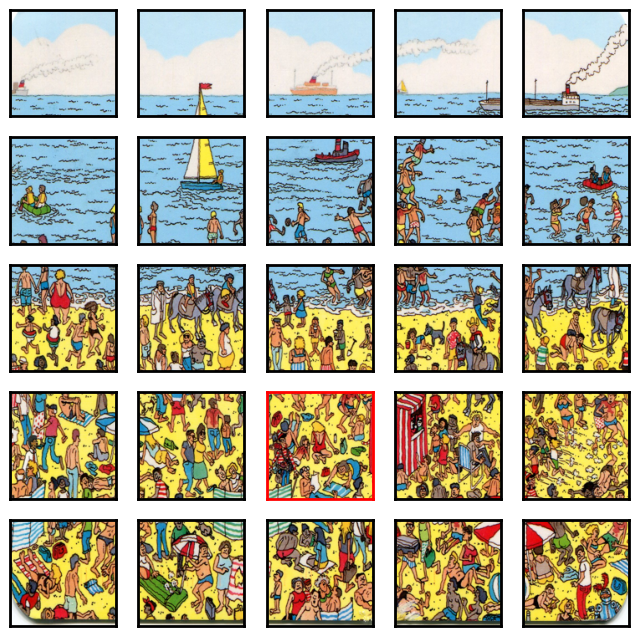

In [155]:
def show_image_patches(dataset, patches_div):
    # Choose a random index for image
    random_index = random.randint(0, len(dataset) - 1)
    # Get the image and label
    img, waldo_lbl = dataset[random_index]

    # Patchify image
    patches_div = 5
    depth, height, width = img.shape
    patches_h = height // patches_div
    patches_w = width // patches_div
    patchified_img = img.unfold(1, patches_h, patches_h).unfold(2, patches_w, patches_w)

    # Get Waldo patch idx
    waldo_mid = (waldo_lbl[:2] + waldo_lbl[2:]) / 2
    waldo_patch_h = int(waldo_mid[1] / (height / patches_div))
    waldo_patch_w = int(waldo_mid[0] / (width / patches_div))

    # Display the random chosen image with the label
    fig, axs = plt.subplots(patches_div, patches_div, figsize=(8, 8))
    for i, ax_row in enumerate(axs):
        for j, ax in enumerate(ax_row):
            patch = patchified_img[:, i, j, :, :].permute(1, 2, 0)
            ax.imshow(patch)
            ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                if i == waldo_patch_h and j == waldo_patch_w:
                    spine.set_edgecolor('red')
    plt.show()

show_image_patches(full_image_dataset, 5)

In [118]:
class PatchBasedClassification(nn.Module):
    def __init__(self, classifier, patches_div):
        self.classifier = classiefier
        self.patches_div = patches_div
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()


    def forward(self, x):
        # Patchify image
        batch_size, depth, height, width = x.shape
        patches_h = height // self.patches_div
        patches_w = width // self.patches_div
        x = x.unfold(2, patches_h, patches_h).unfold(3, patches_w, patches_w)

        # Run through classifier
        x = self.classifier(x)

        # Calculate probabilities per patch
        x = self.sigmoid(x)
        x = self.softmax(x)
        x = x.reshape(batch_size, self.patches_div * self.patches_div)
        
        return x       

In [ ]:
def patches_lbl_from_boxes(boxes_lbl, img_shape, patches_div):
    _*, height, width = img_shape
    prd_mid = (boxes_lbl[..., :2] + boxes_lbl[..., 2:]) / 2
    prd_patch_h = np.floor(prd_mid[..., 1] / (height / patches_div), dtype=int)
    prd_patch_w = np.floor(prd_mid[..., 0] / (width / patches_div), dtype=int)
    
    patches_prd = np.zeros(len(boxes_prd), patches_div, patches_div)
    patches_prd[..., prd_patch_h, prd_patch_w] = 1

    return patches_prd

def boxes_from_patches_prd(patches_prd, img_shape, patches_div):
    patches_max = patches_prd.argmax(-1)
    patches_max_idx = np.concatenate([
        np.array([divmod(idx.item(), patches_div)])
        for idx in patches_max
    ])

    _*, height, width = img_shape
    boxes_prd = np.zeros(len(patches_prd), 4)
    boxes_prd[..., 0] = np.floor(patches_max_idx[..., 1] * (width / patches_div))
    boxes_prd[..., 1] = np.floor(patches_max_idx[..., 0] * (height / patches_div))
    boxes_prd[..., 2] = np.floor((patches_max_idx[..., 1] + 1) * (width / patches_div))
    boxes_prd[..., 3] = np.floor((patches_max_idx[..., 0] + 1) * (height / patches_div))

    return boxes_prd 

In [ ]:
def train_object_epoch(model, train_loader, optimizer, loss_fn, device, patches_div=5, map_iou_threshold=0.5):
    model.train()
    total_loss = 0
    train_boxes_prd = []
    train_boxes_lbl = []

    for img_batch, boxes_lbl in train_loader:
        img_batch = img_batch.to(device)

        optimizer.zero_grad()

        patches_prd = model(img_batch)
        patches_lbl = patches_prd_from_boxes(boxes_lbl, img_batch.shape, patches_div)

        patches_prd_flat = patches_prd.reshape(-1, patches_div ** 2)
        patches_lbl_flat = patches_lbl.reshape(-1, patches_div ** 2)

        loss = loss_fn(patches_prd_flat, patches_lbl_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Store predicted boxes and label boxes
        boxes_prd = boxes_from_patches_prd(patches_prd, img_batch.shape, patches_div)
        train_boxes_prd.append(boxes_prd)
        train_boxes_lbl.append(boxes_lbl)

    avg_loss = total_loss / len(train_loader)
    train_boxes_prd = np.concatenate(train_boxes_prd)
    train_boxes_lbl = np.concatenate(train_boxes_lbl)
    train_ious = calculate_iou(train_boxes_prd, train_boxes_lbl)
    train_map = calculate_iou(train_boxes_prd, train_boxes_lbl, iou_threshold=map_iou_threshold)

    return avg_loss, np.mean(train_ious), train_map


def object_evaluate(model, val_loader, loss_fn, device, patches_div=5, map_iou_threshold=0.5):
    model.eval()
    total_loss = 0
    eval_boxes_prd = []
    eval_boxes_lbl = []

    with torch.no_grad():
        for img_batch, boxes_lbl in val_loader:
            img_batch = img_batch.to(device)

            patches_prd = model(img_batch)
            patches_lbl = patches_prd_from_boxes(boxes_lbl, img_batch.shape, patches_div)

            patches_prd_flat = patches_prd.reshape(-1, patches_div ** 2)
            patches_lbl_flat = patches_lbl.reshape(-1, patches_div ** 2)

            loss = loss_fn(patches_prd_flat, patches_lbl_flat)
            total_loss += loss.item()

            # Store predicted boxes and label boxes
            boxes_prd = boxes_from_patches_prd(patches_prd, img_batch.shape, patches_div)
            eval_boxes_prd.append(boxes_prd)
            train_boxes_lbl.append(boxes_lbl)

    avg_loss = total_loss / len(train_loader)
    eval_boxes_prd = np.concatenate(eval_boxes_prd)
    eval_boxes_lbl = np.concatenate(eval_boxes_lbl)
    eval_ious = calculate_iou(eval_boxes_prd, eval_boxes_lbl)
    eval_map = calculate_iou(eval_boxes_prd, eval_boxes_lbl, iou_threshold=map_iou_threshold)

    return avg_loss, np.mean(eval_ious), eval_map

In [ ]:
num_epochs = 20
patches_div = 5

learning_rate = 1e-3
train_losses = []
train_iou = []
train_map = []
val_losses = []
val_iou = []
val_map = []


# Prepare for training and evaluation
full_img_model = PatchBasedClassification(triplet_model, patches_div).to(device) ####################
optimizer = torch.optim.Adam(full_img_model.parameters(), lr=learning_rate)
ce_loss = nn.CrossEntropyLoss()


for epoch in tqdm(range(num_epochs), desc='Training Progress'):
    t_loss, t_iou, t_map = train_object_epoch(full_img_model, train_loader_step_3, optimizer, ce_loss, device)
    train_losses.append(t_loss)
    train_iou.append(t_iou)
    train_map.append(t_map)

    v_loss, v_iou, v_map = object_evaluate(full_img_model, val_loader_step_3, ce_loss, device)
    train_losses.append(t_loss)
    train_iou.append(t_iou)
    train_map.append(t_map)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


# After training, plot the losses and distances
plt.figure(figsize=(15, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
epochs = list(range(1, num_epochs + 1))
plt.plot(epochs, epoch_positive_distances, label='Mean Positive Distance')
plt.plot(epochs, epoch_negative_distances, label='Mean Negative Distance')
plt.xlabel('Epoch')
plt.ylabel('Mean Distance')
plt.title('Mean Positive and Negative Distances per Epoch')
plt.legend()

# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# Save the model state
model_save_path = './checkpoints/model_state_dict.pth'
torch.save(model.state_dict(), model_save_path)